# Problem Set 3

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Question 1: Predicting Default

### a). We will use the column "loan_status" as the indicator for whether the loan was paid or there was a default.

#### i). Drop all rows where "loan_status" is not equal to either "Fully Paid" or "Charged Off." Define the new variable Default as 1 (or TRUE) if "loan_status" is equal to "Charged Off", and 0 (or FALSE) otherwise.

In [2]:
data = pd.read_csv("LendingClub_LoanStats3a_v12.csv")
data = data[data["loan_status"].isin(["Fully Paid", "Charged Off"])]

data["Default"] = data["loan_status"] == "Charged Off"
data[["loan_status", "Default"]]

,loan_status,Default
0,Fully Paid,False
1,Charged Off,True
2,Fully Paid,False
3,Fully Paid,False
5,Fully Paid,False
...,...,...
39781,Fully Paid,False
39782,Fully Paid,False
39783,Fully Paid,False
39784,Fully Paid,False


#### ii). Report the average default rate in the sample (number of defaults divided by total number of loans).

In [3]:
print(f"{data["Default"].sum()/len(data)*100:.2f}%")

14.35%


### b). LendingClub gives a "grade" to each borrower, designed as a score of each borrowers creditworthiness. The best grade is "A", the worst grade is "G".

#### i). Run a logistic regression of the Default variable on the grade. Report and explain the regression output. I.e., what is the interpretation of the coefficients? Do the numbers 'make sense'.

In [4]:
data["Default"] = data["Default"].astype(int)

X = pd.get_dummies(data["grade"], drop_first=True)
X = sm.add_constant(X)
X = X.astype(float)
y = data["Default"]

regression = sm.Logit(y, X)
result = regression.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.392196
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                39412
Model:                          Logit   Df Residuals:                    39405
Method:                           MLE   Df Model:                            6
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                 0.04651
Time:                        11:53:53   Log-Likelihood:                -15457.
converged:                       True   LL-Null:                       -16211.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7554      0.042    -65.554      0.000      -2.838      -2.673
B              0.7614      0.

#### ii). Construct and report a test of whether the model performs better than the null model where only "beta0", and no conditioning information, is present in the logistic model. 

#### iii). Construct the lift table and the ROC curve for this model. [When constructing these, think a little about the nature of your model. For instance, does it make sense to use deciles in the lift table or would a different type of cutoff be more sensible?] Explain the interpretation of the numbers in the lift table and the lines and axis in the ROC curve. Does the model perform better than a random guess?

### c). Next, we will see if it is possible to do better than the internal "grade"-variable, using other information about the borrower and the loan as provided by LendingClub.

#### i). First, consider a logistic regression model that uses only loan amount (loan_amnt) and annual income (annual_inc) as explanatory variables. Report the regression results. Show the lift table, comparing to the 'grade'-model from a. Plot the ROC curves of both the 'grade'-model and the alternative model. Which model performs better?

In [5]:
X = data[["loan_amnt", "annual_inc"]].copy()
X = sm.add_constant(X)
X = X.astype(float)
y = data["Default"]

regression = sm.Logit(y, X)
result = regression.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.406307
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                39412
Model:                          Logit   Df Residuals:                    39409
Method:                           MLE   Df Model:                            2
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                 0.01221
Time:                        11:57:10   Log-Likelihood:                -16013.
converged:                       True   LL-Null:                       -16211.
Covariance Type:            nonrobust   LLR p-value:                 1.121e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7254      0.032    -53.708      0.000      -1.788      -1.662
loan_amnt   3.484e-05   2.08e

In [8]:
y_pred = result.predict(X)
X_grade = pd.get_dummies(data["grade"], drop_first=True)
X_grade = sm.add_constant(X_grade).astype(float)
model_grade = sm.Logit(y, X_grade).fit()
y_pred_grade = model_grade.predict(X_grade)
def lift_table(y_true, y_scores, n_bins=10):
    df = pd.DataFrame({
        'actual': y_true,
        'score': y_scores
    })
    df['bucket'] = pd.qcut(df['score'], n_bins, duplicates='drop')

    grouped = df.groupby('bucket', as_index=False).agg(
        total=('actual', 'count'),
        events=('actual', 'sum')
    )
    grouped['event_rate'] = grouped['events'] / grouped['total']
    grouped['cum_events'] = grouped['events'].cumsum()
    grouped['cum_event_rate'] = grouped['cum_events'] / grouped['events'].sum()
    
    return grouped.sort_values(by='bucket', ascending=False)
print("Lift Table - Loan Amount + Income Model")
print(lift_table(y, y_pred))

print("\nLift Table - Grade Model")
print(lift_table(y, y_pred_grade))


Optimization terminated successfully.
         Current function value: 0.392196
         Iterations 7
Lift Table - Loan Amount + Income Model
                             bucket  total  events  event_rate  cum_events  \
9                    (0.264, 0.568]   3942    1234    0.313039        5657   
8                    (0.198, 0.264]   3941     929    0.235727        4423   
7                    (0.165, 0.198]   3941     739    0.187516        3494   
6                    (0.143, 0.165]   3941     622    0.157828        2755   
5                    (0.123, 0.143]   3941     572    0.145141        2133   
4                    (0.107, 0.123]   3941     459    0.116468        1561   
3                   (0.0903, 0.107]   3941     390    0.098960        1102   
2                  (0.0744, 0.0903]   3941     317    0.080436         712   
1                  (0.0611, 0.0744]   3941     251    0.063689         395   
0  (-0.0009999999999999755, 0.0611]   3942     144    0.036530         144   


#### ii). Now, include also information from the loan itself. In particular, include the maturity of the loan (term) and the interest rate (int_rate) in the logistic regression. Report the output. How does Python handle the term variable? In particular, what is the interpretation of the regression coefficient? Again show the lift table and ROC curve relative to the original 'grade' model. Now, which model is better? What is the likely explanation for why this new model performs better/worse?

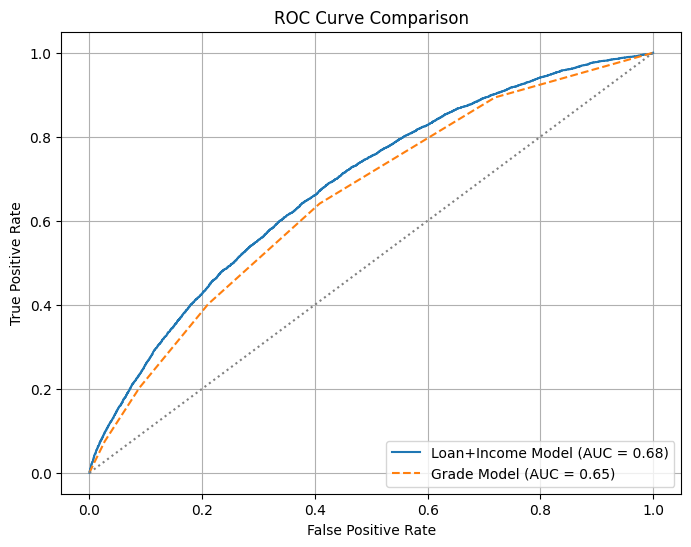

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC for loan_amnt + annual_inc
fpr1, tpr1, _ = roc_curve(y, y_pred)
roc_auc1 = auc(fpr1, tpr1)

# ROC for grade model
fpr2, tpr2, _ = roc_curve(y, y_pred_grade)
roc_auc2 = auc(fpr2, tpr2)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Loan+Income Model (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'Grade Model (AUC = {roc_auc2:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [7]:
data["term"] = data["term"].str.extract("(\d+)").astype(int)

X = data[["loan_amnt", "annual_inc", "term", "int_rate"]].copy()
X = sm.add_constant(X)
X = X.astype(float)
y = data["Default"]

regression = sm.Logit(y, X)
result = regression.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.385901
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                39412
Model:                          Logit   Df Residuals:                    39407
Method:                           MLE   Df Model:                            4
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                 0.06182
Time:                        17:10:46   Log-Likelihood:                -15209.
converged:                       True   LL-Null:                       -16211.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9467      0.070    -56.455      0.000      -4.084      -3.810
loan_amnt   1.176e-06   2.31e

#### iii). Create the squared of the interest rate and add this variable to the last model. Is the coefficient on this variable significant? Please give an intuition for what the coefficients on both int_rate and its squared value imply for the relationship between defaults and the interest rate.